In [1]:
import pandas as pd
import numpy as np
from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed, RNN, Lambda, Concatenate
from keras.layers.merge import Multiply
from keras.models import Model
from keras.losses import mean_squared_error
from keras.models import Model
import keras.backend as K
# from keras.losses import mean_squared_error
def rmse(actual, preds):
    return np.sqrt(np.mean((actual - preds)**2))

Using TensorFlow backend.


# Right now make as many assumptions as possible

It's better to ask it
- derive speeds
- separate x and y. mby use same module for both?
- learn bounces separately
     - is LSTM much better if there is only 1 frame after the bounce vs 0?

In [128]:
## Straight movement, derive speed

from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed, RNN, Lambda

# This returns a tensor
inputs = Input(shape=(4,1,))
# inputs = Input(shape=(10,1))

# a layer instance is callable on a tensor, and returns a tensor
x = LSTM(4, return_sequences=False)(inputs)
x = Dense(2)(x)

predictions = x#Dense(2, input_shape=(4,1))(x)

# This creates a model that includes
# the Input layer and three Dense layers
model_ws = Model(inputs=inputs, outputs=predictions)
model_ws.compile(loss=mean_squared_error,
              optimizer='adam',
              metrics=['accuracy'])
model_ws.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 4, 1)              0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 10        
Total params: 106
Trainable params: 106
Non-trainable params: 0
_________________________________________________________________


In [129]:
df = pd.read_csv('sim_data2.csv')
# x, x_vel, y, y_vel
a = df.to_numpy()
a = a.reshape((20000,5,4)) #samples x timesteps x features
X = a[:,:4,0].reshape(20000,4,1) #np.delete(a, [1,3], axis=2)[:,:10,:]
Y = a[:,4,:2] #.reshape(10000,5,2)

train_X = X[:8000]
train_Y = Y[:8000]

# test_X = X[8000:]
# test_Y = Y[8000:]
model_ws.fit(train_X, train_Y, epochs=50, verbose=False)

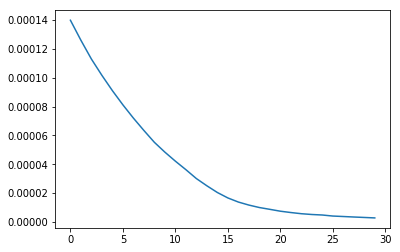

In [132]:
plt.plot(model_ws.history.history['loss'][20:])

In [ ]:
save_

In [133]:
test_X = X[8000:]
test_Y = Y[8000:]
rmse(test_Y, model_ws.predict(test_X))

0.0015452199107973228

In [134]:
rmse(train_Y, model_ws.predict(train_X))

0.0015610769274912613

In [137]:
model_ws.predict(train_X[[100]])

array([[0.56464034, 0.021955  ]], dtype=float32)

In [138]:
a[100,:5,:2]

array([[0.48099345, 0.02076668],
       [0.50176013, 0.02076668],
       [0.52252681, 0.02076668],
       [0.54329348, 0.02076668],
       [0.56406016, 0.02076668]])

In [9]:
# model_json = model_ws.to_json()
# with open("sim_e500_8000x5.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model_ws.save_weights("model_sim_e500_8000x5.h5")
# print("Saved model to disk")

# Bounces

In [16]:
inputs = Input(shape=(2,))

x = Dense(2)(inputs)

predictions = x#Dense(4, input_shape=(4,1))(x)

# This creates a model that includes
# the Input layer and three Dense layers
model_b = Model(inputs=inputs, outputs=predictions)
model_b.compile(loss=mean_squared_error,
              optimizer='adam',
              metrics=['accuracy'])
model_b.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


In [17]:
df = pd.read_csv('bounces_mirror.csv')
a = df.to_numpy()
a = a.reshape((2000,2,4)) #samples x timesteps x features
a = a[:,:,:2]
train_X = a[:1000,0,:]
test_X = a[1000:,0,:]
train_Y = a[:1000,1,:]
test_Y = a[1000:,1,:]
model_b.fit(train_X, train_Y, epochs=1500, verbose=False)

In [18]:
print(rmse(test_Y, model_b.predict(test_X)))
print(rmse(train_Y, model_b.predict(train_X)))

0.0011277298251766233
0.0011069609699923433


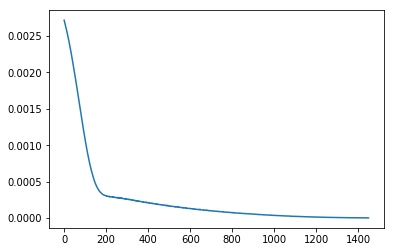

In [19]:
import matplotlib.pyplot as plt
plt.plot(model_b.history.history['loss'][50:])
plt.show()

In [20]:
model_b.predict(train_X[[0]])

array([[ 0.9725745 , -0.07040136]], dtype=float32)

In [21]:
model_json = model_b.to_json()
with open("sim_e1500_b.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_b.save_weights("model_e1500_b.h5")
print("Saved model to disk")

Saved model to disk


### Attention

In [23]:
inputs = Input(shape=(2,))
x = Dense(1)(inputs)
predictions = x

model_att = Model(inputs=inputs, outputs=predictions)
model_att.compile(loss=mean_squared_error,
              optimizer='adam',
              metrics=['accuracy'])
model_att.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [25]:
df.head()

,x,y,is_bounce
0,1.046797,0.468502,True
1,0.985927,0.322979,False
2,1.089176,0.434555,True
3,1.021509,0.965619,True
4,0.993019,0.172505,False


In [80]:
df = pd.read_csv('bounces_att.csv')
a = df.to_numpy()
train_X = a[:1500,:2]
test_X = a[1500:,:2]
train_Y = (a[:1500,2] == True)
test_Y = (a[1500:,2] == True)
model_att.fit(train_X, train_Y, epochs=1500, verbose=False)

In [81]:
inputs = Input(shape=(2,))

x = model_att(inputs)
x = Lambda(lambda s: K.round(s))(x)
predictions = x
model_lambda = Model(inputs=inputs, outputs=predictions)
model_lambda.compile(loss=mean_squared_error,
              optimizer='adam',
              metrics=['acc'])
model_lambda.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
model_5 (Model)              (None, 1)                 3         
_________________________________________________________________
lambda_11 (Lambda)           (None, 1)                 0         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [82]:
print(np.mean(model_lambda.predict(train_X).reshape(train_X.shape[0]) == train_Y))
print(np.mean(model_lambda.predict(test_X).reshape(test_X.shape[0]) == test_Y))

0.9866666666666667
0.994


In [20]:
model_json = model_lambda.to_json()
with open("sim_e1500_att.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_lambda.save_weights("model_e1500_att.h5")
print("Saved model to disk")

Saved model to disk


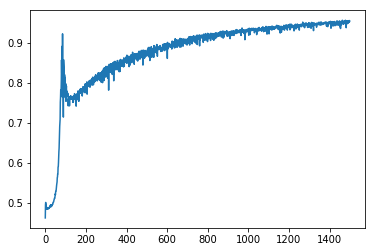

In [21]:
plt.plot(model_att.history.history['acc'])

## Bounce series

In [139]:
df = pd.read_csv('bounces_x_1.csv')
a = df.to_numpy()
a = a.reshape((1000,5,4))

X = a[:,:4,0].reshape(1000,4,1) #np.delete(a, [1,3], axis=2)[:,:10,:]
Y = a[:,4,:2] #.reshape(10000,5,2)

train_X = X[:800]
train_Y = Y[:800]

test_X = X[800:]
test_Y = Y[800:]

In [ ]:
K.concatenate(x)

In [280]:
inputs_rec = Input(shape=(4,1), name='input_rec')
rec = model_ws(inputs_rec)
bnc = model_b(rec)
att = model_att(rec)
att2 = Lambda(lambda s: K.switch(K.greater_equal(s[0], 0.5), s[1], s[2]))([att, bnc, rec]) #~hard attention

x = att2

model_m = Model(inputs=inputs_rec, outputs=x)
model_m.compile(loss=mean_squared_error,
              optimizer='adam',
              metrics=['accuracy'])
model_m.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_rec (InputLayer)          (None, 4, 1)         0                                            
__________________________________________________________________________________________________
model_19 (Model)                (None, 2)            106         input_rec[0][0]                  
__________________________________________________________________________________________________
model_5 (Model)                 (None, 1)            3           model_19[5][0]                   
__________________________________________________________________________________________________
model_4 (Model)                 (None, 2)            6           model_19[5][0]                   
__________________________________________________________________________________________________
lambda_19 

In [281]:
a[:2,:4,:2]

array([[[0.90050525, 0.03311408],
        [0.93361933, 0.03311408],
        [0.96673341, 0.03311408],
        [0.99984749, 0.03311408]],

       [[0.96741627, 0.01082775],
        [0.97824402, 0.01082775],
        [0.98907176, 0.01082775],
        [0.99989951, 0.01082775]]])

In [282]:
model_m.predict(X[:2])

array([[ 0.9671812 , -0.03348778],
       [ 0.98777086, -0.01078438]], dtype=float32)

In [283]:
df2 = pd.read_csv('sim_data_borders.csv')
# x, x_vel, y, y_vel
a2 = df2.to_numpy()
a2 = a2.reshape((4000,5,4)) #samples x timesteps x features
X2 = a2[:,:4,0].reshape(4000,4,1) #np.delete(a, [1,3], axis=2)[:,:10,:]
Y2 = a2[:,4,:2] #.reshape(10000,5,2)

train_X2 = X2[:8000]
train_Y2 = Y2[:8000]

In [284]:
a2[:5,:4,:2]

array([[[ 0.71763805, -0.02578439],
        [ 0.69185366, -0.02578439],
        [ 0.66606926, -0.02578439],
        [ 0.64028487, -0.02578439]],

       [[ 0.58871608, -0.02578439],
        [ 0.56293168, -0.02578439],
        [ 0.53714729, -0.02578439],
        [ 0.5113629 , -0.02578439]],

       [[ 0.45979411, -0.02578439],
        [ 0.43400971, -0.02578439],
        [ 0.40822532, -0.02578439],
        [ 0.38244092, -0.02578439]],

       [[ 0.33087214, -0.02578439],
        [ 0.30508774, -0.02578439],
        [ 0.27930335, -0.02578439],
        [ 0.25351895, -0.02578439]],

       [[ 0.16579863,  0.06713727],
        [ 0.2329359 ,  0.06713727],
        [ 0.30007317,  0.06713727],
        [ 0.36721044,  0.06713727]]])

In [285]:
model_m.predict(X2[:2])

array([[ 0.6146241 , -0.02395917],
       [ 0.48554268, -0.0239506 ]], dtype=float32)

## Training data, where series leading to bounce and straight movement are 1-1

In [237]:
df.shape

(5000, 4)

In [238]:
df2.shape

(20000, 4)

In [239]:
mixdf = pd.concat([df, df2[:5000]])
mix = mixdf.to_numpy()
mix = mix.reshape(2000,5,4)
np.random.shuffle(mix)
mix_train_x = mix[:1800,:4,0].reshape(1800,4,1)
mix_train_y = mix[:1800,4,:2]
mix_test_x = mix[1800:,:4,0].reshape(200,4,1)
mix_test_y = mix[1800:,4,:2]
rmse(mix_test_y, model_m.predict(mix_test_x)) # My model

In [287]:
# n2n model
inputs = Input(shape=(4,1))
x = LSTM(4, return_sequences=False)(inputs)
x = Dense(4)(x)
x = Dense(4)(x)
x = Dense(2)(x)
model_n2n = Model(inputs=inputs, outputs=x)
model_n2n.compile(loss=mean_squared_error,
              optimizer='adam',
              metrics=['accuracy'])
model_n2n.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 4, 1)              0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 10        
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [288]:
model_n2n.fit(mix_train_x, mix_train_y, epochs=100)

Epoch 1/100
1800/1800 [==============================] - 1s 658us/step - loss: 0.2844 - acc: 0.8222
Epoch 2/100
1800/1800 [==============================] - 0s 148us/step - loss: 0.1095 - acc: 0.9883
Epoch 3/100
1800/1800 [==============================] - 0s 147us/step - loss: 0.0482 - acc: 0.9883
Epoch 4/100
1800/1800 [==============================] - 0s 148us/step - loss: 0.0324 - acc: 0.9883
Epoch 5/100
1800/1800 [==============================] - 0s 149us/step - loss: 0.0179 - acc: 0.9883
Epoch 6/100
1800/1800 [==============================] - 0s 147us/step - loss: 0.0078 - acc: 0.9883
Epoch 7/100
1800/1800 [==============================] - 0s 148us/step - loss: 0.0063 - acc: 0.9811
Epoch 8/100
1800/1800 [==============================] - 0s 154us/step - loss: 0.0061 - acc: 0.9822
Epoch 9/100
1800/1800 [==============================] - 0s 159us/step - loss: 0.0060 - acc: 0.9839
Epoch 10/100
1800/1800 [==============================] - 0s 150us/step - loss: 0.0058 - acc: 0.9828

In [289]:
rmse(mix_test_y, model_n2n.predict(mix_test_x))

0.03488781341520831

In [295]:
b = mix_test_x[:3]

In [301]:
b

array([[[7.47851902e-01],
        [8.31834078e-01],
        [9.15816255e-01],
        [9.99798432e-01]],

       [[9.08947685e-01],
        [9.39292739e-01],
        [9.69637794e-01],
        [9.99982848e-01]],

       [[1.21226836e-01],
        [6.06293150e-02],
        [3.17937938e-05],
        [6.05657274e-02]]])

In [299]:
model_m.predict(b)

array([[ 0.9212596 , -0.08373384],
       [ 0.96960855, -0.03068657],
       [ 0.0408061 ,  0.01272298]], dtype=float32)

In [300]:
model_n2n.predict(b)

array([[ 1.0237702 , -0.02749126],
       [ 0.99790883, -0.04591396],
       [ 0.07502958,  0.0361006 ]], dtype=float32)

In [303]:
b[2,1] - b[2 ,0]

array([-0.06059752])